Tema: Simulação de Tráfego e Mobilidade Urbana. 

 A simulação de tráfego e mobilidade urbana é um campo de estudo que se concentra em modelar e prever o movimento dos veículos em ambientes urbanos. Este campo permite-nos analisar como diferentes políticas de trânsito podem impactar na eficiência e na sustentabilidade do sistema de transporte de uma cidade. Através da utilização de técnicas de modelagem computacional avançadas, é possível simular cenários hipotéticos e avaliar os efeitos de intervenções como a implementação de faixas exclusivas de transporte público, restrições de tráfego, expansão de redes de ciclovias e outras medidas de gestão de tráfego. Estas simulações podem fornecer informações valiosas para a tomada de decisões informadas, contribuindo para o planeamento de cidades mais acessíveis, eficientes e sustentáveis.
 
Para tal escolhemos este data set com mais 10.000 ocorrencias de trânsito. o data set localiza-se aqui:https://dados.cm-lisboa.pt/en/dataset/condicionamentos-de-transito-historico

O principal objetivo é, por exemplo, descobrir se as horas que ocorrem mais condicionamentos, o porquê de existirem e se a duração afeta o impacto.

Grupo nº6: Henrique Ponte, Miguel Carvalho & Miguel Viveiros. 

In [156]:
# Bibliotecas para manipulação de dados
import pandas as pd
import numpy as np
import ast
from shapely.geometry import MultiLineString
import geopandas as gpd

# Bibliotecas para visualização de dados
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import plotly.express as px

# Bibliotecas para machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder

# Biblioteca para análise de cluster
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


from sklearn.tree import DecisionTreeClassifier, plot_tree
import json
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree

dados = pd.read_csv('transito.csv')

In [157]:
dados.head(10)

,entity_id,impacto,restricao_circulacao,morada,periodos_condicionamentos,motivo,position,creation_date
0,EMEL.condicionamentoTransito.COND-2021-767-1,Relevante,Estreitamento de via,Alto da Boavista/Rotunda Pina Manique/Estrada ...,"[{'end_date': '1616011200000', 'date_min': '20...",OBRA - FAIXA DE RODAGEM,"{'type': 'GeometryCollection', 'geometries': [...",2021-02-04 10:00:09
1,EMEL.condicionamentoTransito.COND-2021-1499-3,Pouco relevante,Estacionamento,"Avenida dos Estados Unidos da América, nº97 e 95","[{'end_date': '1616018400000', 'date_min': '20...",FILMAGENS,"{'type': 'GeometryCollection', 'geometries': [...",2021-03-09 14:44:49
2,EMEL.condicionamentoTransito.COND-2021-1572-A-1,Relevante,Estreitamento de via,Avenida Professor Egas Moniz ft. ao CHULN/HOSP...,"[{'end_date': '1616018400000', 'date_min': '20...",CONCENTRAÇÃO,"{'type': 'GeometryCollection', 'geometries': [...",2021-03-11 12:46:02
3,EMEL.condicionamentoTransito.COND-2021-1499-4,Pouco relevante,Estacionamento,Rua Pereira Henriques entre os nºs 26 - 14,"[{'end_date': '1616018400000', 'date_min': '20...",FILMAGENS,"{'type': 'GeometryCollection', 'geometries': [...",2021-03-09 14:47:00
4,EMEL.condicionamentoTransito.COND-2020-6258-51,Relevante,Corte total,2.ª Circular - entre o IP7 {Eixo N/S} e o ramo...,"[{'end_date': '1616047200000', 'date_min': '20...",REPAVIMENTAÇÕES,"{'type': 'GeometryCollection', 'geometries': [...",2021-03-16 14:33:56
5,EMEL.condicionamentoTransito.COND-2020-2950-PA-24,Relevante,Estreitamento de via,"Praça dos Restauradores,79-80/Rua Jardim do Re...","[{'end_date': '1616054400000', 'date_min': '20...",CARGAS E DESCARGAS/OBRAS,"{'type': 'GeometryCollection', 'geometries': [...",2021-02-22 17:05:34
6,EMEL.condicionamentoTransito.COND-2021-1117-12,Relevante,Mantém perfil de via,Rua do Zaire,"[{'end_date': '1616781600000', 'date_min': '20...",PINTURAS,"{'type': 'GeometryCollection', 'geometries': [...",2021-02-22 14:07:03
7,EMEL.condicionamentoTransito.COND-2021-1117-4,Pouco relevante,Mantém perfil de via,Rua Maria Andrade,"[{'end_date': '1616781600000', 'date_min': '20...",PINTURAS,"{'type': 'GeometryCollection', 'geometries': [...",2021-02-22 13:49:38
8,EMEL.condicionamentoTransito.COND-2021-1662-A-1,Relevante,Passeio,Banco Santander Totta - Banco Santander Totta,"[{'end_date': '1616072400000', 'date_min': '20...",CONCENTRAÇÃO,"{'type': 'GeometryCollection', 'geometries': [...",2021-03-16 10:38:31
9,EMEL.condicionamentoTransito.COND-2021-1622-1,Relevante,Estreitamento de via,"Praça da Constituição de 1976, Frente à Assemb...","[{'end_date': '1616090400000', 'date_min': '20...",CONCENTRAÇÃO,"{'type': 'GeometryCollection', 'geometries': [...",2021-03-15 09:36:38


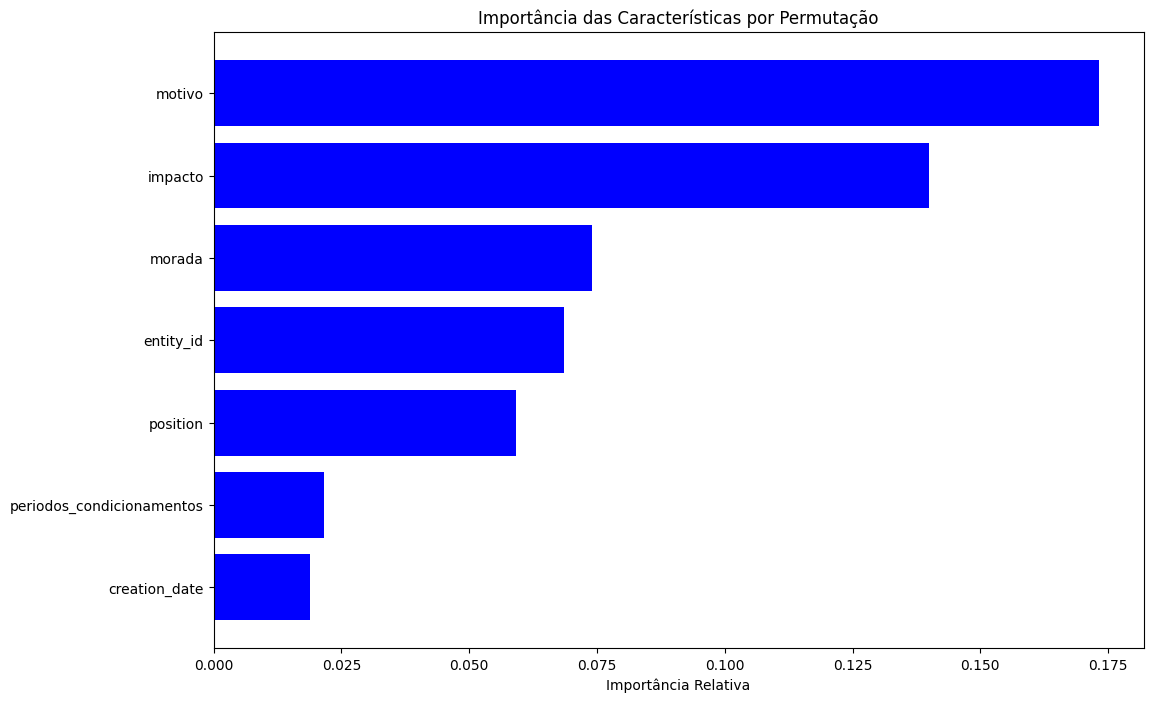

In [158]:
# Codificar as características categóricas usamos o Label enconder
encoders = {}
for col in dados.columns:
    if dados[col].dtype == 'object':
        dados[col] = dados[col].astype(str)
        
        le = LabelEncoder()
        dados[col] = le.fit_transform(dados[col])
        encoders[col] = le


coluna_alvo = 'restricao_circulacao'

# Separar as características e o alvo
X = dados.drop(coluna_alvo, axis=1)
y = dados[coluna_alvo]

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar um modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Calcule a importância das características por permutação
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Obtenha a importância das características e os nomes das características
importances = result.importances_mean
feature_names = X_test.columns.tolist()

# Ordene as características pela importância
indices = np.argsort(importances)

plt.figure(figsize=(12, 8))
plt.title("Importância das Características por Permutação")
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importância Relativa')
plt.show()



Os dados recolhidos apresentam 8 colunas. Com a seguinte informação:
- entity_id
  - Informação que guarda: Refere-se ao identificador do condicionamento
  - Escala de medida: Escala Nominal
  - Unidade: N/A

- impacto
  - Informação que guarda: Refere-se ao nível de impacto na circulação (por exemplo, "Pouco relevante")
  - Escala de medida: Escala Ordinal
  - Unidade: N/A

- restricao_circulacao
  - Informação que guarda: Refere-se ao tipo de restrição à circulação (por exemplo, "Estacionamento")
  - Escala de medida: Escala Nominal
  - Unidade: N/A

- morada
  - Informação que guarda: Refere-se à morada do condicionamento
  - Escala de medida: Escala Nominal
  - Unidade: N/A

- periodos_condicionamentos
  - Informação que guarda: Refere-se à data de início e data de fim do condicionamento
  - Escala de medida: Escala de Intervalo
  - Unidade: Milissegundos desde a época Unix (1 de janeiro de 1970)

- motivo
  - Informação que guarda: Refere-se ao motivo do condicionamento (por exemplo, "FILMAGENS")
  - Escala de medida: Escala Nominal
  - Unidade: N/A

- position
  - Informação que guarda: Refere-se às coordenadas (latitude/longitude)
  - Escala de medida: Escala de Rácios
  - Unidade: Graus

- creation_date
  - Informação que guarda: Refere-se à data em que o condicionamento foi registado
  - Escala de medida: Escala de Intervalo
  - Unidade: Data e hora

PRÉ-PROCESSAMENTO

O pré-processamento de dados é uma etapa essencial na análise de dados e machine learning que inclui:

1. Limpeza de dados: Trata dados em falta e ruído.
2. Transformação de dados: Melhora a eficácia dos algoritmos de mineração de dados.
3. Redução de dados: Remove dados redundantes ou irrelevantes.

A escolha das técnicas depende do conjunto de dados e do problema a ser resolvido. O pré-processamento pode ser aplicado a dados estruturados, semiestruturados e não estruturados. É uma etapa que melhora a qualidade dos dados, levando a resultados mais precisos e confiáveis.

Para além da remoção dos outliers removemos as seguintes colunas entity_id e creation_date porque as mesmas não sao relevantes para a nossa análise


In [159]:
# Remover as colunas menos relevantes
dados = dados.drop(['entity_id', 'creation_date'], axis=1)

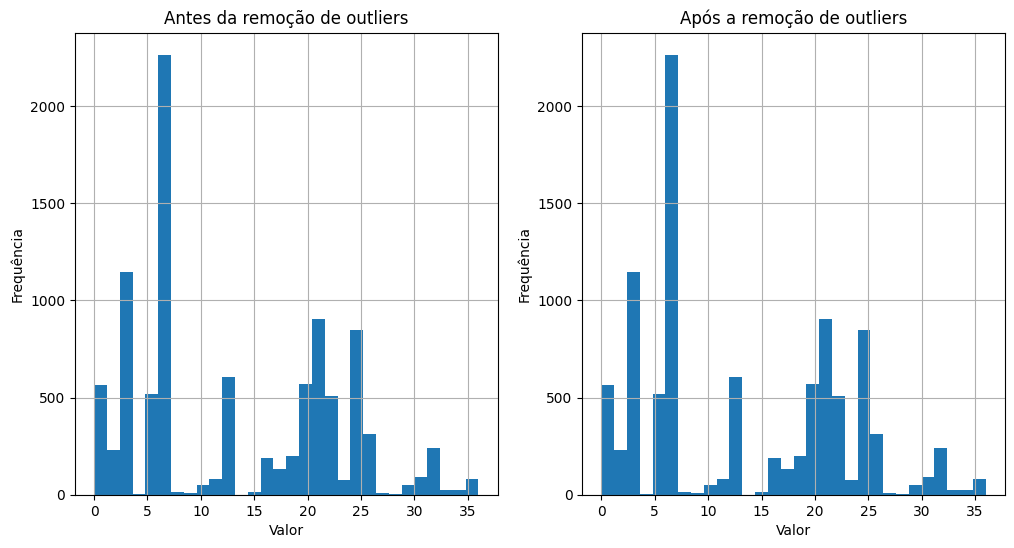

In [160]:
coluna = 'motivo'

# Antes da remoção de outliers
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
dados[coluna].hist(bins=30)
plt.title('Antes da remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Remoção de outliers
Q1 = dados[coluna].quantile(0.25)
Q3 = dados[coluna].quantile(0.75)
IQR = Q3 - Q1
filtro = (dados[coluna] >= Q1 - 1.5 * IQR) & (dados[coluna] <= Q3 + 1.5 *IQR)
df_filtrado = dados.loc[filtro]

# Após a remoção de outliers
plt.subplot(1,2,2)
df_filtrado[coluna].hist(bins=30)
plt.title('Após a remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

plt.show()


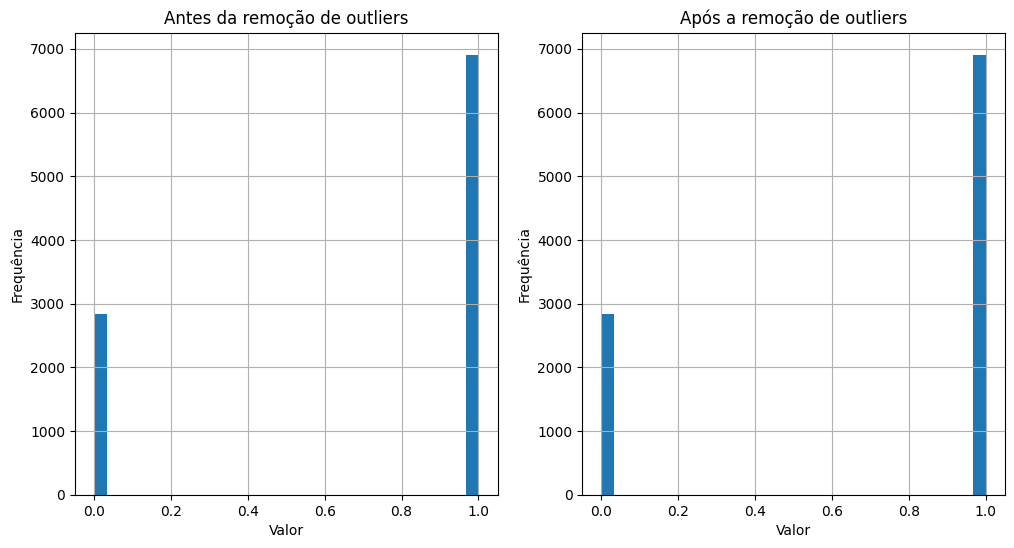

In [161]:
coluna = 'impacto'

# Antes da remoção de outliers
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
dados[coluna].hist(bins=30)
plt.title('Antes da remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Remoção de outliers
Q1 = dados[coluna].quantile(0.25)
Q3 = dados[coluna].quantile(0.75)
IQR = Q3 - Q1
filtro = (dados[coluna] >= Q1 - 1.5 * IQR) & (dados[coluna] <= Q3 + 1.5 *IQR)
df_filtrado = dados.loc[filtro]

# Após a remoção de outliers
plt.subplot(1,2,2)
df_filtrado[coluna].hist(bins=30)
plt.title('Após a remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

plt.show()


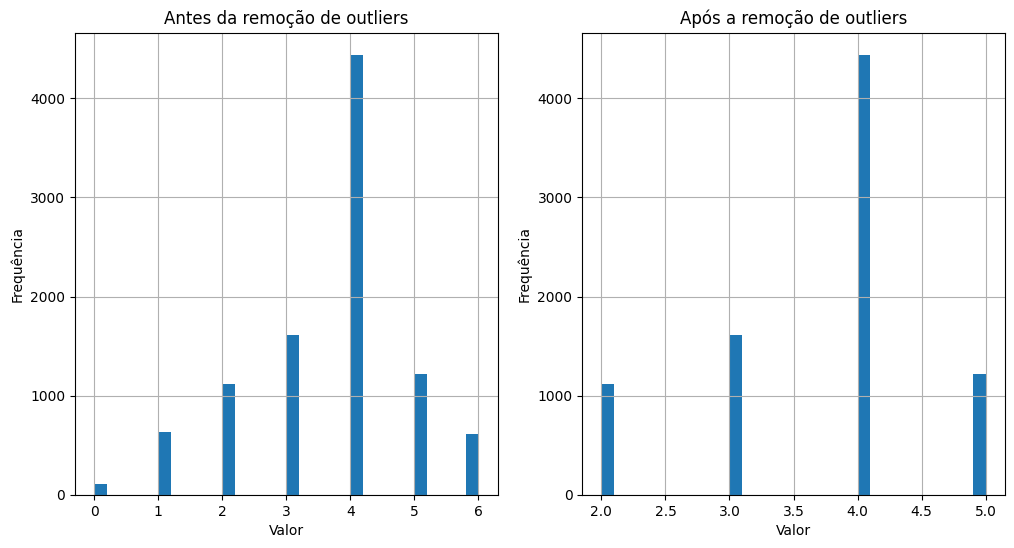

In [162]:
coluna = 'restricao_circulacao'

# Antes da remoção de outliers
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
dados[coluna].hist(bins=30)
plt.title('Antes da remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Remoção de outliers
Q1 = dados[coluna].quantile(0.25)
Q3 = dados[coluna].quantile(0.75)
IQR = Q3 - Q1
filtro = (dados[coluna] >= Q1 - 1.5 * IQR) & (dados[coluna] <= Q3 + 1.5 *IQR)
df_filtrado = dados.loc[filtro]

# Após a remoção de outliers
plt.subplot(1,2,2)
df_filtrado[coluna].hist(bins=30)
plt.title('Após a remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

plt.show()


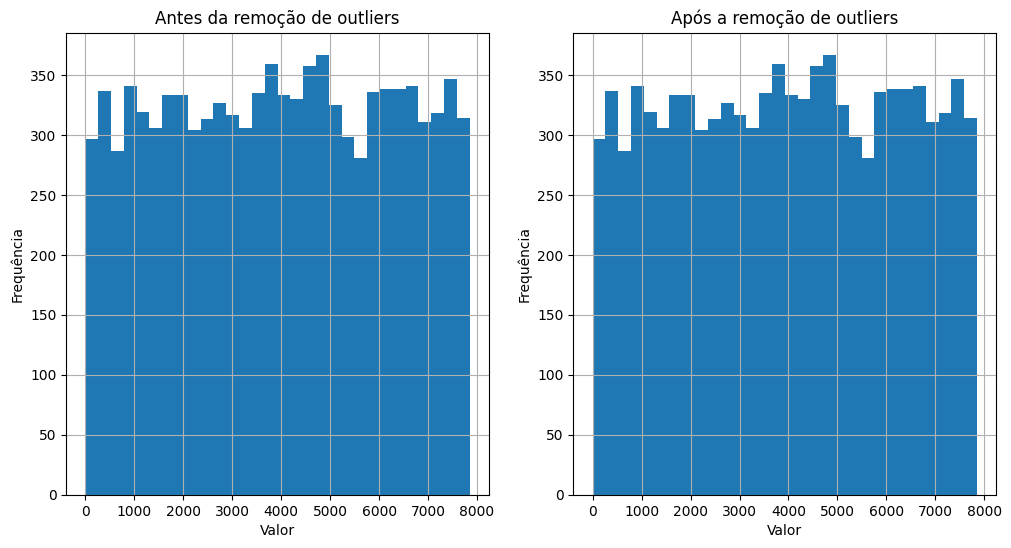

In [163]:
coluna = 'position'

# Antes da remoção de outliers
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
dados[coluna].hist(bins=30)
plt.title('Antes da remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Remoção de outliers
Q1 = dados[coluna].quantile(0.25)
Q3 = dados[coluna].quantile(0.75)
IQR = Q3 - Q1
filtro = (dados[coluna] >= Q1 - 1.5 * IQR) & (dados[coluna] <= Q3 + 1.5 *IQR)
df_filtrado = dados.loc[filtro]

# Após a remoção de outliers
plt.subplot(1,2,2)
df_filtrado[coluna].hist(bins=30)
plt.title('Após a remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

plt.show()


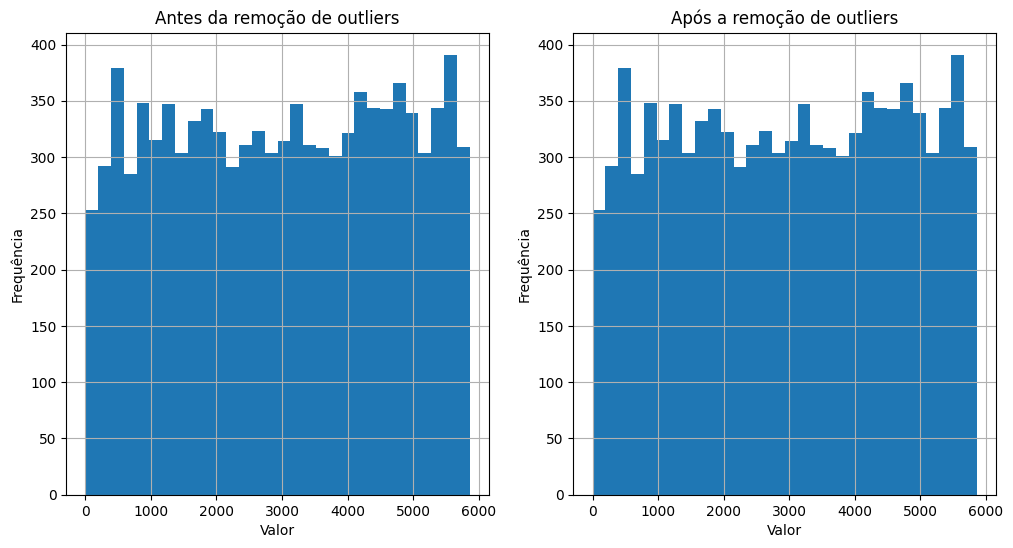

In [164]:
coluna = 'periodos_condicionamentos'

# Antes da remoção de outliers
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
dados[coluna].hist(bins=30)
plt.title('Antes da remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Remoção de outliers
Q1 = dados[coluna].quantile(0.25)
Q3 = dados[coluna].quantile(0.75)
IQR = Q3 - Q1
filtro = (dados[coluna] >= Q1 - 1.5 * IQR) & (dados[coluna] <= Q3 + 1.5 *IQR)
df_filtrado = dados.loc[filtro]

# Após a remoção de outliers
plt.subplot(1,2,2)
df_filtrado[coluna].hist(bins=30)
plt.title('Após a remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

plt.show()


Após o tratamento dos dados inciamos por fazer alguns graficos relacionando as nossas colunas a procura de padrões e relações.

Como se pode averiguar pelos gráficos obtidos, os dados do dataset já se encontram bem organizados e não exigiram um grande tratamento, isto porque não existem grandes diferenças quando se compara o "antes" e o "depois" no que diz respeito aos outliers para cada coluna.

In [165]:
# Agora, para decodificar como queremos que mostre os dados categoricos e não em números
for col in dados.columns:
    if col in encoders:
        dados[col] = encoders[col].inverse_transform(dados[col])


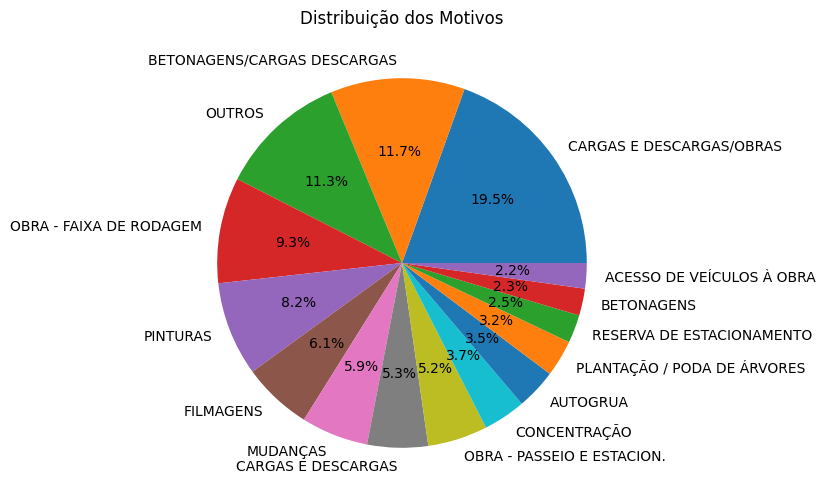

In [166]:
dados_copia = dados.copy()

contagem_motivos = dados_copia['motivo'].value_counts()

percentagem_motivos = 100 * contagem_motivos / contagem_motivos.sum()

outros = percentagem_motivos < 2

dados_copia['motivo'] = dados_copia['motivo'].where(~dados_copia['motivo'].isin(percentagem_motivos.index[outros]), 'OUTROS')

# Contar a frequência dos motivos novamente
contagem_motivos = dados_copia['motivo'].value_counts()

# Criar o gráfico circular
plt.figure(figsize=(10, 6))
plt.pie(contagem_motivos, labels = contagem_motivos.index, autopct='%1.1f%%')
plt.title('Distribuição dos Motivos')
plt.show()

fig = px.pie(dados_copia, names='motivo', title='Distribuição dos Motivos')
fig.show()

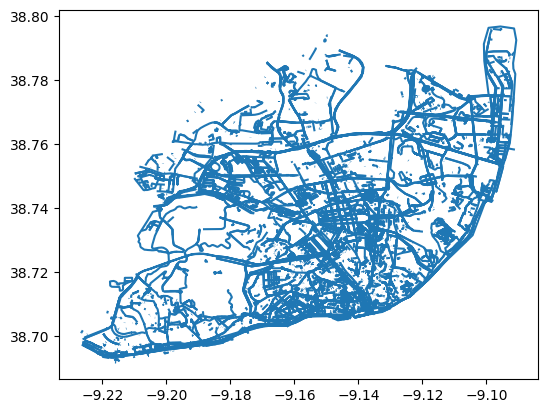

In [167]:
# Converter a coluna 'position' de string para um objeto Python (dicionário)
dados['position'] = dados['position'].apply(ast.literal_eval)

# Criar uma GeoDataFrame a partir das geometrias
gdf = gpd.GeoDataFrame(dados, geometry=[MultiLineString(geom['geometries'][0]['coordinates']) for geom in dados['position']])

# Visualizar as geometrias
gdf.plot()
plt.show()

1. Converte uma coluna de ‘strings’ para um dicionário.
2. Cria um GeoDataFrame usando as geometrias extraídas dessa coluna.
3. Visualiza essas geometrias num gráfico.

A imagem que acompanha o código é um gráfico de dados geográficos, representando estradas de Lisboa que sofreram algum tipo de condicionamento.

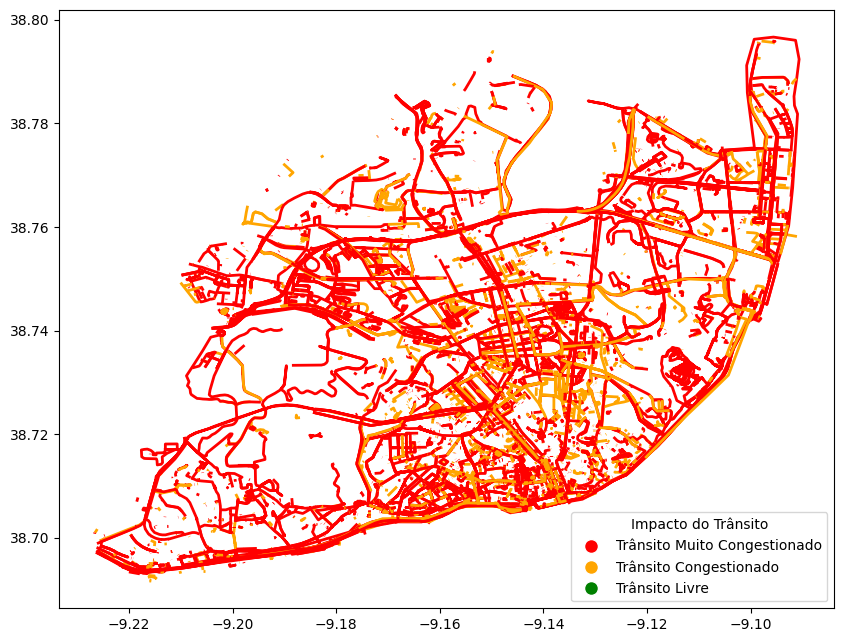

In [168]:
# Criação de GeoDataFrame
gdf = gpd.GeoDataFrame(dados, geometry=[MultiLineString(geom['geometries'][0]['coordinates']) for geom in dados['position']])

# Mapeamento de Cores
colors = {'Relevante': 'red', 'Pouco relevante': 'orange', 'Livre': 'green'}

# Adicionando uma coluna de cores com base no impacto do trânsito
gdf['color'] = dados['impacto'].map(colors)

# Visualização com Cores
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color=gdf['color'], linewidth=2)

# Adicionando uma legenda
legend_labels = {'Relevante': 'Trânsito Muito Congestionado', 'Pouco relevante': 'Trânsito Congestionado', 'Livre': 'Trânsito Livre'}
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[impacto], markersize=10, label=label) for impacto, label in legend_labels.items()]
ax.legend(handles=legend_handles, title='Impacto do Trânsito', loc='lower right')

plt.show()

1. Cria um GeoDataFrame com base nas geometrias extraídas de uma coluna de dados.
2. Mapeia cores para diferentes níveis de impacto do trânsito.
3. Adiciona uma coluna de cores ao GeoDataFrame com base no impacto do trânsito.
4. Visualiza os dados num gráfico, com as cores indicando o impacto do trânsito.
5. Adiciona uma legenda ao gráfico para explicar o significado das cores.

A imagem que acompanha o código é um mapa que mostra as condições de trânsito em lisboa, com diferentes cores indicando diferentes níveis de impacto do trânsito.

Legendas: legend_labels = {'Relevante': 'Trânsito Muito Congestionado', 'Pouco relevante': 'Trânsito Congestionado', 'Livre': 'Trânsito Livre'}

Importante notar que nao aparece verde porque no nosso dataset esta cor corresponde a estradas onde o trânsito não está congestionado, ou seja, estradas livres. Como o dataset não possui informação dos nomes das ruas e das posições destas, em nenhum ponto será possível visualizar as restantes cidades de Lisboa. Porém, como se definiu uma variavel "Trânsito Livre" poderá incluir-se futuramente informação sobre este tipo de estradas, no caso do dataset ser melhorado ou ampliado.

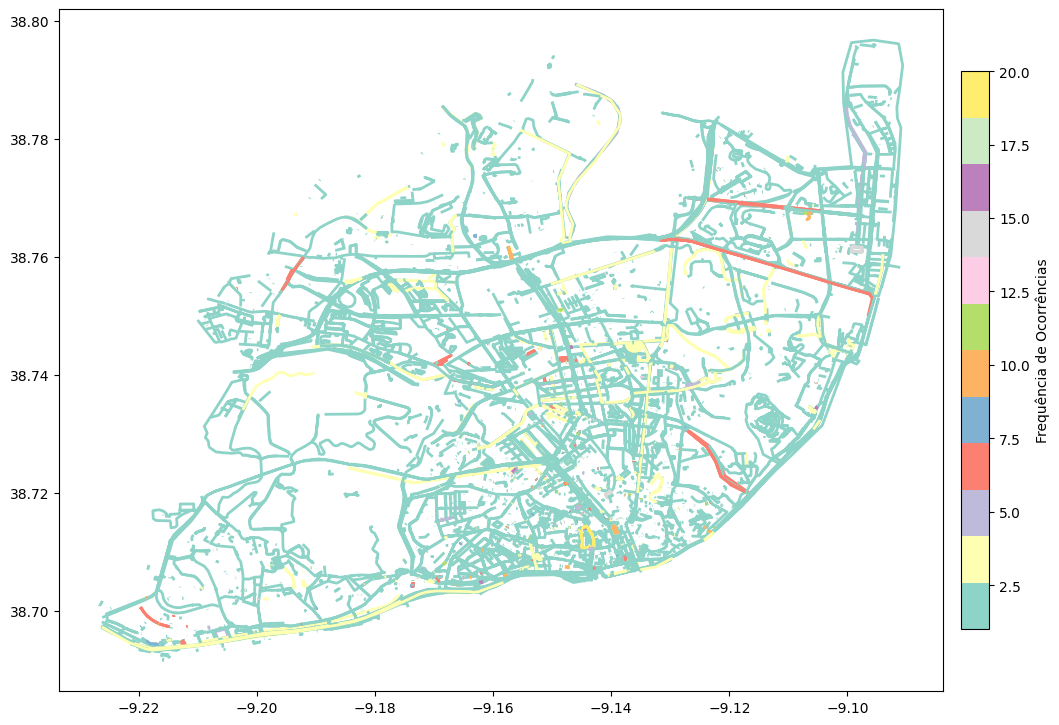

In [169]:
# Criação de GeoDataFrame
gdf = gpd.GeoDataFrame(dados, geometry=[MultiLineString(geom['geometries'][0]['coordinates']) for geom in dados['position']])

# Contar a frequência de cada morada
contagem_moradas = dados['morada'].value_counts()

# Normalizar a escala de cores com base na frequência
norm = Normalize(vmin=min(contagem_moradas), vmax=max(contagem_moradas))
mapper = ScalarMappable(norm=norm, cmap='Set3')

# Adicionando uma coluna de cores com base na frequência de ocorrências
gdf['color'] = dados['morada'].map(lambda x: mapper.to_rgba(contagem_moradas[x]))

# Visualização com Cores
fig, ax = plt.subplots(figsize=(12, 12))
gdf.plot(ax=ax, color=gdf['color'], linewidth=2)

# Adicionando uma barra de cores
cbar = fig.colorbar(mapper, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)
cbar.set_label('Frequência de Ocorrências')

plt.show()


1. Criação de GeoDataFrame: Um GeoDataFrame é criado a partir de dados existentes, onde a coluna de geometria é preenchida com objetos MultiLineString. Esses objetos representam as coordenadas geográficas de diferentes localizações.

2. Contagem de Frequência de Endereços: A frequência de cada endereço nos dados é contada.

3. Normalização de Cor: Uma escala de cores é normalizada com base na frequência dos endereços. Isso é feito usando a função `Normalize` do Matplotlib, que escala os valores de entrada para o intervalo de 0-1.

4. Adição de Coluna de Cor: Uma nova coluna 'color' é adicionada ao GeoDataFrame. Cada endereço é mapeado para uma cor com base na sua frequência de ocorrência.

5. Visualização: O GeoDataFrame é plotado como um mapa, onde a cor de cada linha (representando um endereço) corresponde à sua frequência de ocorrência. O parâmetro linewidth é definido como 2, tornando as linhas duas vezes mais espessas que o padrão.

6. Adição de Barra de Cores: Uma barra de cores é adicionada ao gráfico, que serve como uma legenda para as frequências codificadas por cores. O rótulo da barra de cores é definido como 'Frequência de Ocorrências'.

A imagem, mostra o mapa geográfico de Lisboa com linhas de diferentes cores representando a frequência de ocorrências de diferentes endereços. A barra de cores à direita indica a escala de frequência. Através deste gráfico, consegue-se averiguar quais as estradas de Lisboa que, conforme o dataset, foram mais prejudicadas por condicionamentos.


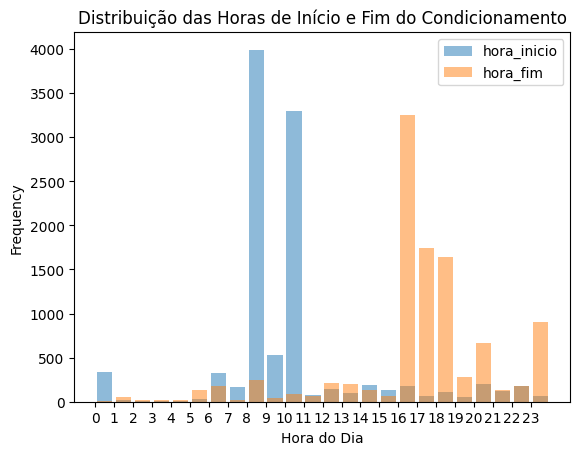

In [170]:
# Extrair as horas de início e fim do condicionamento
dados['hora_inicio_condicionamento'] = dados['periodos_condicionamentos'].apply(lambda x: [i['hour_min'] for i in ast.literal_eval(x)])
dados['hora_fim_condicionamento'] = dados['periodos_condicionamentos'].apply(lambda x: [i['hour_max'] for i in ast.literal_eval(x)])

# Converter as horas para um formato numérico (por exemplo, "08:00:00" se torna 8.0)
dados['hora_inicio_condicionamento'] = dados['hora_inicio_condicionamento'].apply(lambda x: [float(i.split(':')[0]) + float(i.split(':')[1])/60 for i in x])
dados['hora_fim_condicionamento'] = dados['hora_fim_condicionamento'].apply(lambda x: [float(i.split(':')[0]) + float(i.split(':')[1])/60 for i in x])

horas_condicionamento = pd.DataFrame({'hora_inicio': [hora for sublist in dados['hora_inicio_condicionamento'] for hora in sublist],
                                      'hora_fim': [hora for sublist in dados['hora_fim_condicionamento'] for hora in sublist]})

# Plotar um histograma das horas de início e fim do condicionamento
horas_condicionamento[['hora_inicio', 'hora_fim']].plot(kind='hist', rwidth=0.8, alpha=0.5, bins=24)
plt.title('Distribuição das Horas de Início e Fim do Condicionamento')
plt.xlabel('Hora do Dia')
plt.xticks(range(24))
plt.show()

1. Extração das Horas de Início e Fim do Condicionamento: As horas de início e fim do condicionamento são extraídas do campo 'periodos_condicionamentos' do conjunto de dados. Isso é feito aplicando uma função lambda que extrai 'hour_min' e 'hour_max' para cada entrada.

2. Conversão das Horas para um Formato Numérico: As horas extraídas são convertidas para um formato numérico. Por exemplo, "08:00:00" se torna 8.0. Isso é feito dividindo os minutos por 60 e adicionando ao número de horas.

3. Criação de DataFrame das Horas de Condicionamento: Um novo DataFrame 'horas_condicionamento' é criado com as horas de início e fim do condicionamento.

4. Visualização: Um histograma das horas de início e fim do condicionamento é plotado. O eixo x representa a hora do dia e o eixo y representa a frequência. O gráfico tem 24 bins, representando as 24 horas do dia.

A imagem, mostra um histograma que representa a distribuição das horas de início e fim do condicionamento. A maioria dos eventos de "hora_inicio" ocorre por volta da hora 10, com mais de 3500 ocorrências. A maioria dos eventos de "hora_fim" está distribuída entre as horas 14 e 18, atingindo o pico na hora 16 com mais de 3000 ocorrências.

É importante notar que, este histograma só mostra as horas de início e fim do condicionamento, não sendo relevante para determinar o período total dos condicionamentos, perídos estes que em determinadas situações podem demorar vários dias em vez de horas.


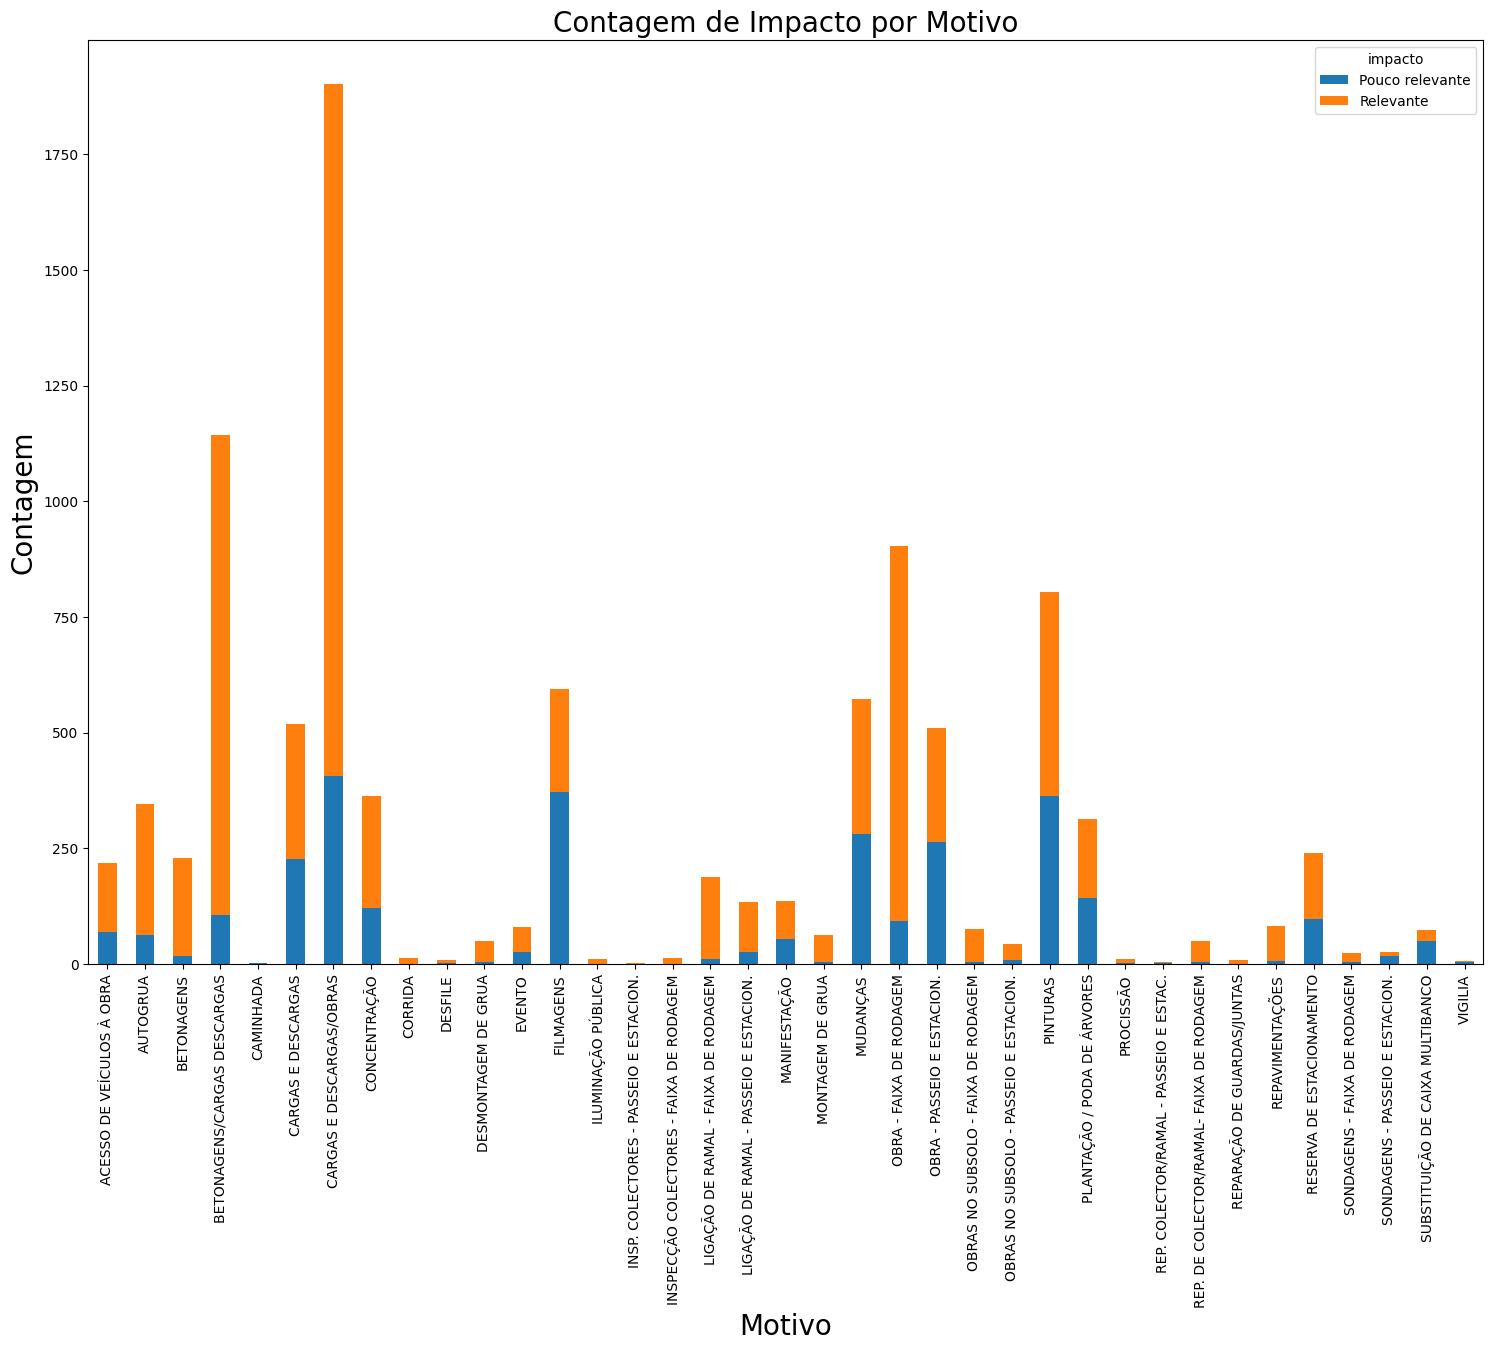

In [171]:
# Contar o número de ocorrências de cada nível de 'impacto' para cada 'motivo'
contagem_impacto_por_motivo = dados.groupby('motivo')['impacto'].value_counts().unstack()

# Criar um gráfico de barras empilhadas
contagem_impacto_por_motivo.plot(kind='bar', stacked=True, figsize=(18,12))
plt.title('Contagem de Impacto por Motivo', fontsize='20')
plt.xlabel('Motivo', fontsize='20')
plt.ylabel('Contagem', fontsize='20')
plt.show()

1. Contagem de Impacto por Motivo: O número de ocorrências de cada nível de 'impacto' para cada 'motivo' é contado. Isso é feito agrupando o DataFrame 'dados' por 'motivo' e contando o número de ocorrências de cada valor de 'impacto'. O resultado é um novo DataFrame onde cada linha corresponde a um 'motivo' e cada coluna corresponde a um nível de 'impacto'.

2. Criação de um Gráfico de Barras Empilhadas: Um gráfico de barras empilhadas é criado a partir do DataFrame 'contagem_impacto_por_motivo'. Cada barra no gráfico representa um 'motivo' sendo dividida em seções coloridas que representam diferentes níveis de 'impacto'. A altura de cada seção colorida corresponde ao número de ocorrências do respetivo nível de 'impacto' para o 'motivo' correspondente.

A imagem, mostra um gráfico de barras empilhadas que representa a contagem de impacto por motivo. Cada barra no gráfico representa um motivo sendo dividida em seções coloridas que representam diferentes níveis de impacto. A altura de cada seção colorida corresponde ao número de ocorrências do respetivo nível de impacto para o motivo correspondente.


**APRENDIZAGEM NÃO SUPERVISIONADA**

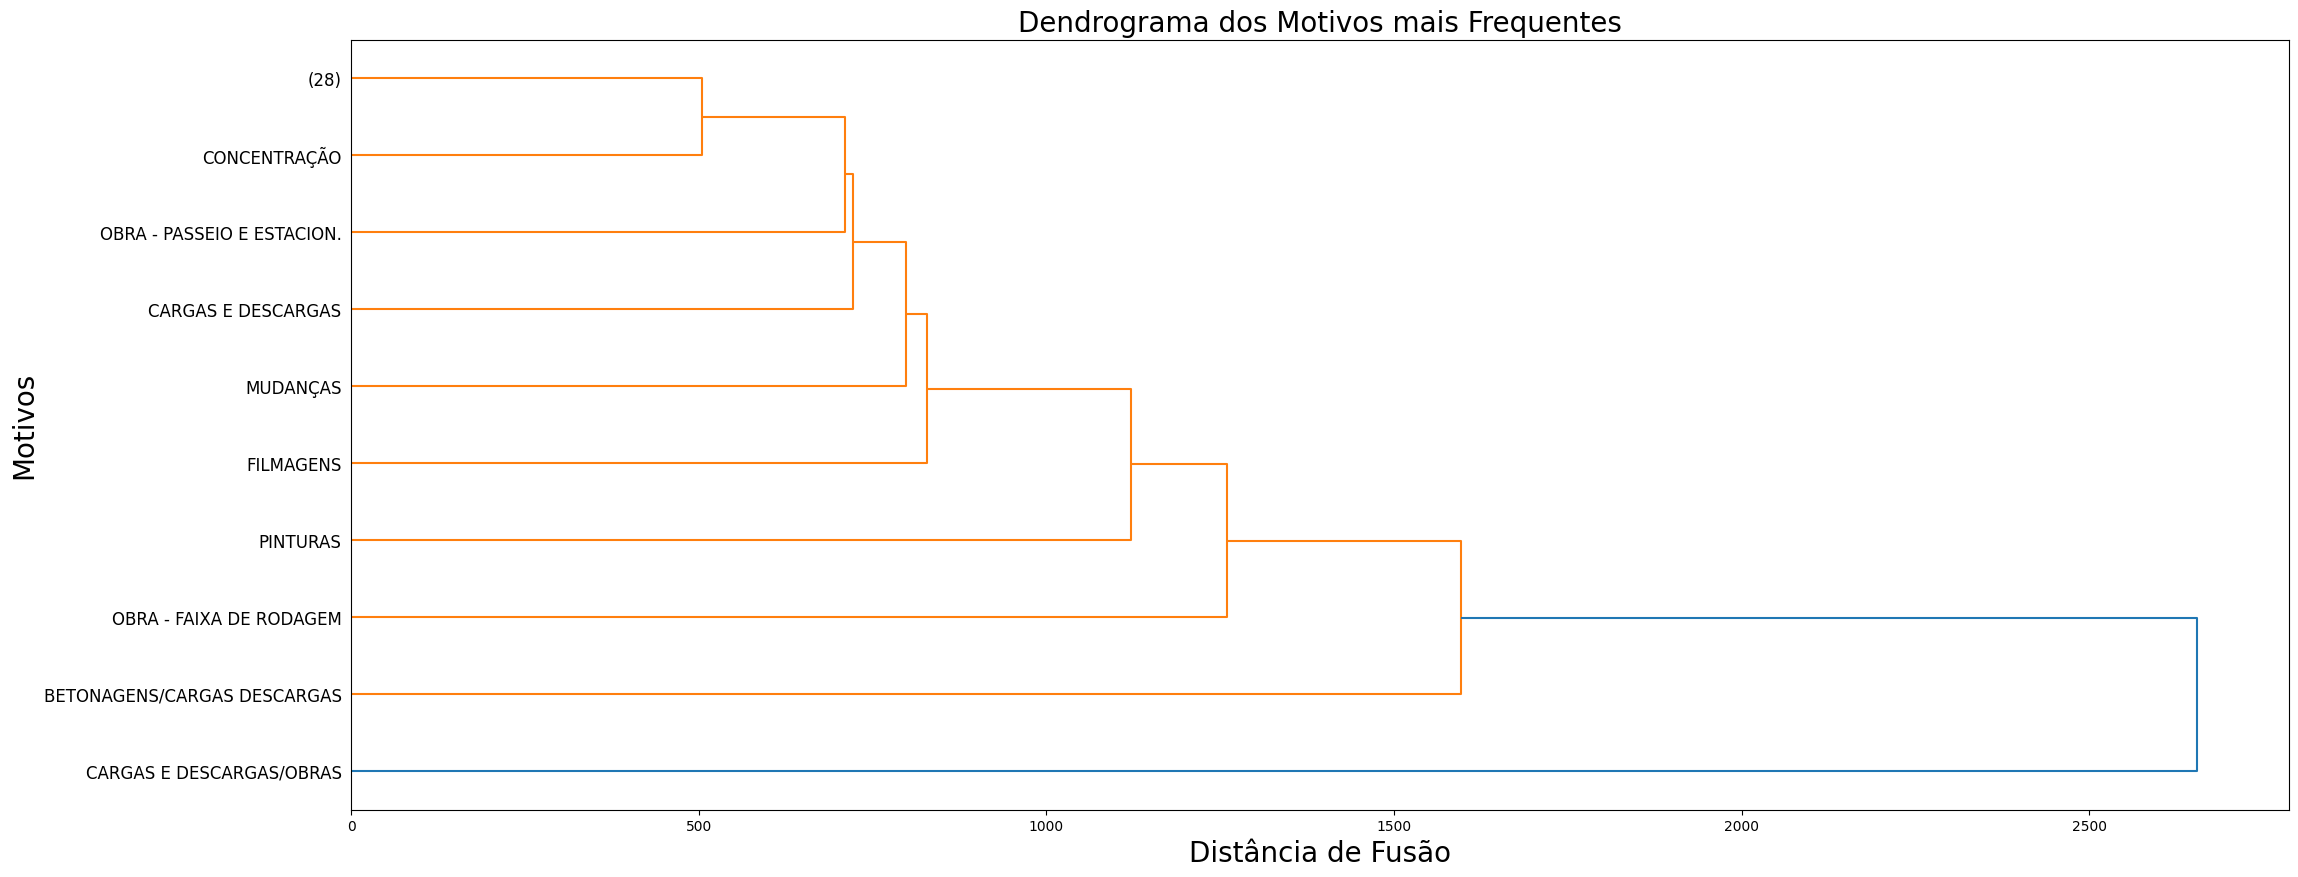

In [172]:
# Criar matriz de distância para o agrupamento hierárquico
dist_matrix = pd.crosstab(dados['motivo'], dados['motivo'])

# Realizar agrupamento hierárquico
linkage_matrix = linkage(dist_matrix, method='ward')

# Plotar o dendrograma
plt.figure(figsize=(25, 10))
dendrogram(linkage_matrix, labels=dist_matrix.index, orientation="right", truncate_mode='lastp', p=10)

plt.title('Dendrograma dos Motivos mais Frequentes', fontsize=20)
plt.xlabel('Distância de Fusão', fontsize=20)
plt.ylabel('Motivos', fontsize=20)
plt.show()

**Dendograma**
O código fornecido é usado para realizar o agrupamento hierárquico dos motivos mais frequentes encontrados num conjunto de dados. Aqui está um resumo:

1. Contagem da Frequência de Cada Motivo: A frequência de cada motivo no conjunto de dados é contada.

2. Criação da Matriz de Distância: Uma matriz de distância é criada usando uma tabulação cruzada dos motivos contra eles mesmos.

3. Realização do Agrupamento Hierárquico: O agrupamento hierárquico é realizado usando o método de Ward, que minimiza a variância total dentro do ‘cluster’.

4. Plotagem do Dendrograma: Finalmente, é plotado um dendrograma visualizando o quão relacionados estão esses motivos principais, com base na sua ocorrência no conjunto de dados. O eixo x representa os motivos e o eixo y representa a distância.

A imagem, mostra um dendrograma que representa o agrupamento hierárquico de vários motivos. Existem vários ‘clusters’ formados em diferentes distâncias, indicando níveis variáveis de similaridade entre motivos como "OBRA - PASSEIO E ESTACION.", "CONCENTRAÇÃO", "CARGAS E DESCARGAS", etc.

In [173]:
def grafCotovelo (linkage_matrix):
    #obter as últimas 15 aglomerações do modelo
    ultimAgl = linkage_matrix[-15:,2]
    # inverter a ordem dos valores
    ultimAgl = ultimAgl[::-1]
    # calculo das diferenças sucessivas divididas pelo maior
    dif = np.diff(ultimAgl, 2)
    # criar o nº de clusters para o eixo horizontal
    noCluster=np.arange(1,len(ultimAgl)+1)
    plt.plot(noCluster,ultimAgl,'bo',noCluster,ultimAgl, noCluster[:-2]+1, dif, 'g-')
    plt.show()

**Gráfico de Cotevelo**

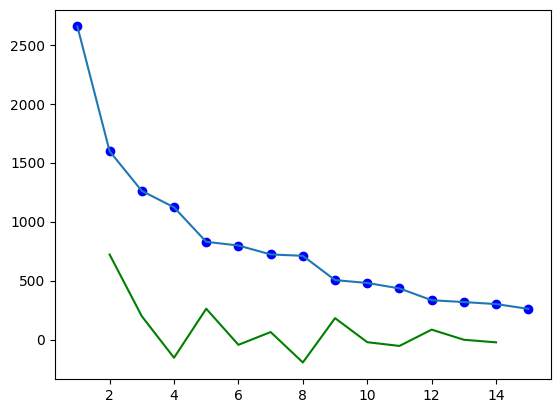

In [174]:
grafCotovelo(linkage_matrix)

O código define uma função chamada `grafCotovelo` que aceita uma matriz de ligação como entrada. Esta função é usada para visualizar o método do cotovelo, permite determinar o número ótimo de agrupamentos.

1. Obtém as últimas 15 aglomerações do modelo a partir da matriz de ligação.
2. Inverte a ordem dos valores das aglomerações.
3. Calcula as diferenças sucessivas desses valores e divide pelo maior valor para normalizar.
4. Cria um gráfico que mostra tanto os valores das aglomerações quanto as diferenças sucessivas.

O gráfico resultante ajuda a identificar o "cotovelo", ou seja, o ponto onde adicionar mais agrupamentos não resulta num ganho significativo na variância explicada. Este ponto é geralmente considerado o número optimal de agrupamentos. 



In [175]:
clusters = fcluster(linkage_matrix, 1700, criterion='distance')
clusters = pd.Categorical(clusters)
clusters.describe()

,counts,freqs
categories,,
1,36,0.972973
2,1,0.027027


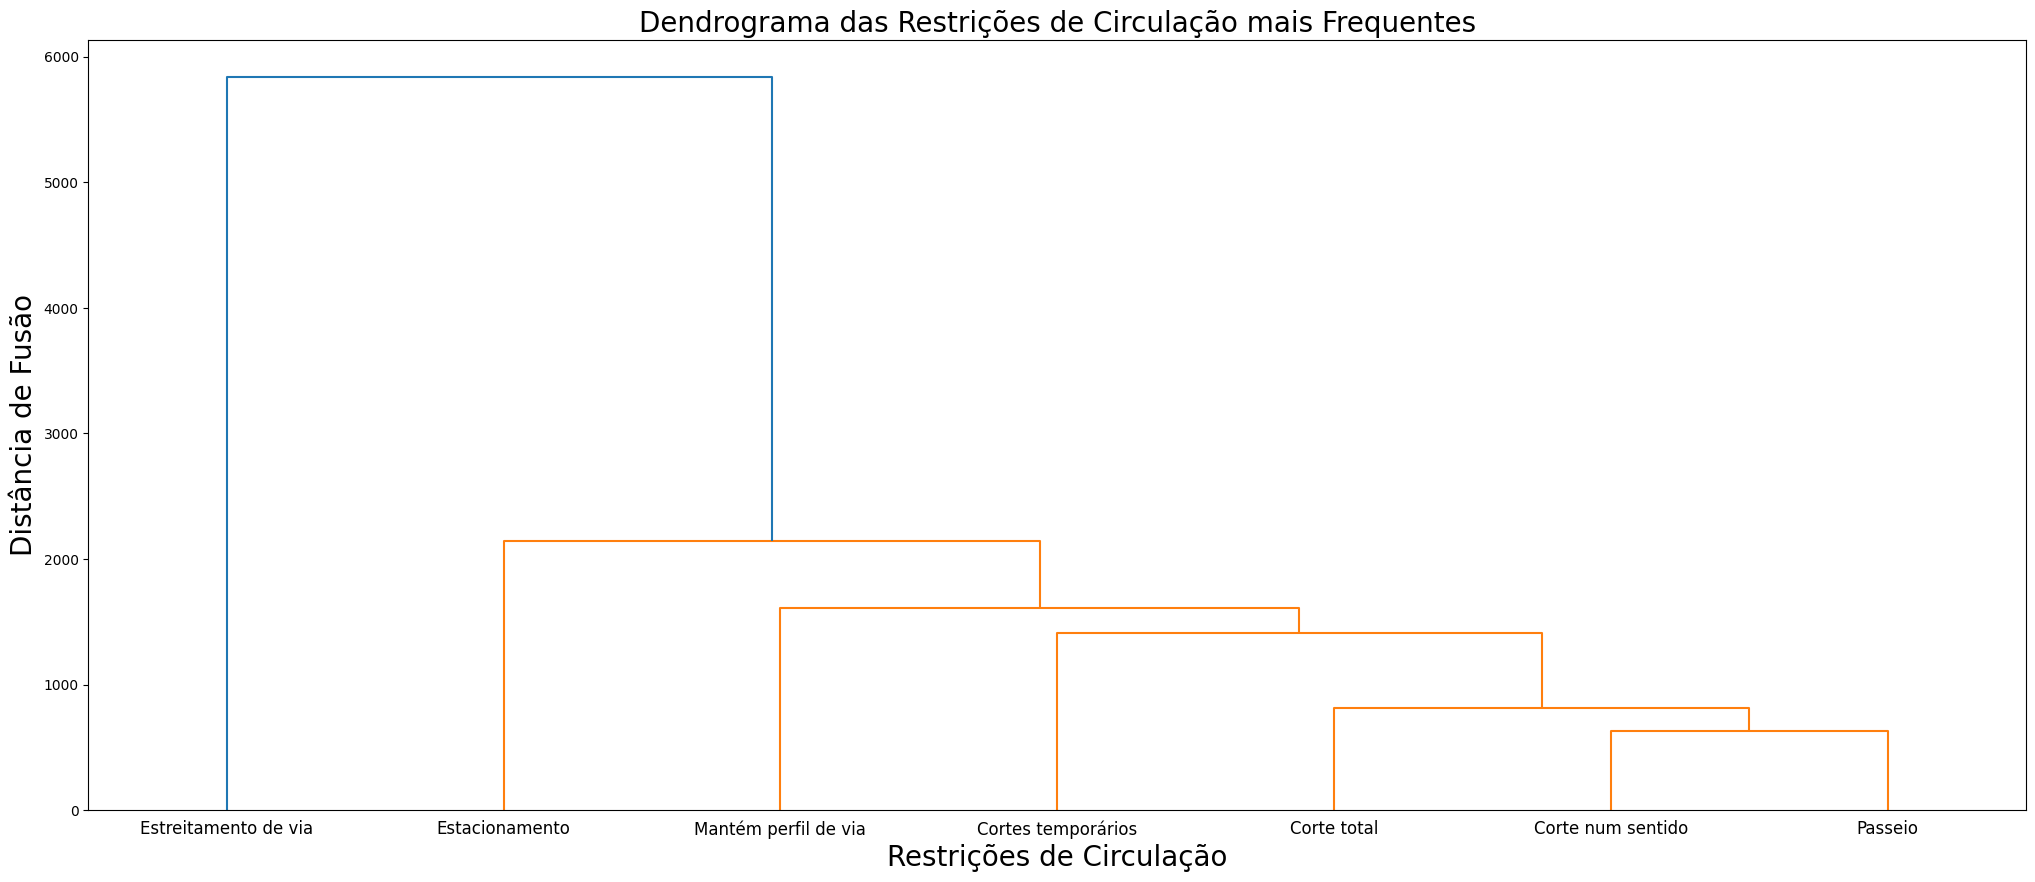

In [176]:
# Criar matriz de distância para o agrupamento hierárquico
dist_matrix = pd.crosstab(dados['restricao_circulacao'], dados['restricao_circulacao'])

# Realizar agrupamento hierárquico
linkage_matrix = linkage(dist_matrix, method='ward')

# Plotar o dendrograma
plt.figure(figsize=(25, 10))
dendrogram(linkage_matrix, labels=dist_matrix.index, orientation="top", truncate_mode='lastp')

plt.title('Dendrograma das Restrições de Circulação mais Frequentes', fontsize=20)
plt.xlabel('Restrições de Circulação', fontsize=20)
plt.ylabel('Distância de Fusão', fontsize=20)
plt.show()

1. Contagem da Frequência de Cada Restrição de Circulação: A frequência de cada restrição de circulação no conjunto de dados é contada.

2. Criação da Matriz de Distância: Uma matriz de distância é criada usando uma tabulação cruzada das restrições de circulação contra elas mesmas.

3. Realização do Agrupamento Hierárquico: O agrupamento hierárquico é realizado usando o método de Ward, que minimiza a variância total dentro do ‘cluster’.

4. Plotagem do Dendrograma: Finalmente, é plotado um dendrograma visualizando o quão relacionadas estão essas restrições de circulação principais, com base na sua ocorrência no conjunto de dados. O eixo x representa as restrições de circulação e o eixo y representa a distância.

A imagem, mostra um dendrograma que representa o agrupamento hierárquico de várias restrições de circulação. Existem vários ‘clusters’ formados em diferentes distâncias, indicando níveis variáveis de similaridade entre restrições como "Estreitamento de via", "Estacionamento", "Mantém perfil de via", etc.


In [177]:
def grafCotovelo (linkage_matrix):
    #obter as últimas 15 aglomerações do modelo
    ultimAgl = linkage_matrix[-15:,2]
    # inverter a ordem dos valores
    ultimAgl = ultimAgl[::-1]
    # calculo das diferenças sucessivas divididas pelo maior
    dif = np.diff(ultimAgl, 2)
    # criar o nº de clusters para o eixo horizontal
    noCluster=np.arange(1,len(ultimAgl)+1)
    plt.plot(noCluster,ultimAgl,'bo',noCluster,ultimAgl, noCluster[:-2]+1, dif, 'g-')
    plt.show()

**Gráfico de Cotevelo**

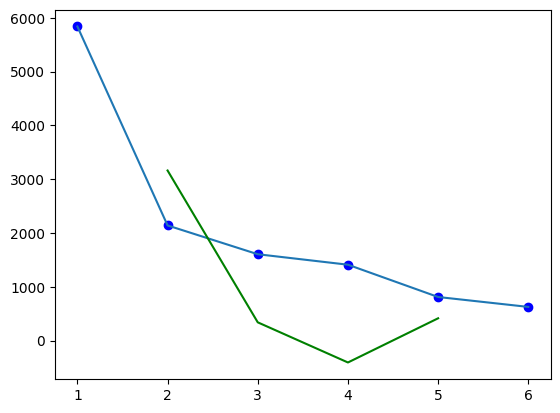

In [178]:
grafCotovelo(linkage_matrix)

In [179]:
clusters = fcluster(linkage_matrix, 2500, criterion='distance')
clusters = pd.Categorical(clusters)
clusters.describe()

,counts,freqs
categories,,
1,6,0.857143
2,1,0.142857


**APRENDIZAGEM SUPERVISIONADAo**

Indução de regras

In [180]:
encoders = {}
for col in dados.columns:
    if dados[col].dtype == 'object':
        dados[col] = dados[col].astype(str)
        
        le = LabelEncoder()
        dados[col] = le.fit_transform(dados[col])
        encoders[col] = le

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(dados.drop('impacto', axis=1), dados['impacto'], test_size=0.2, random_state=42)

# Criando o modelo
model = DecisionTreeClassifier()

# Treinando o modelo
model.fit(X_train, y_train)

# Agora você pode usar o modelo para fazer previsões
predictions = model.predict(X_test)

print(predictions)

# Calculando o F1-score
f1 = f1_score(y_test, predictions, average='weighted')

print('F1-score: ', f1)

[1 1 1 ... 1 1 0]
F1-score:  0.7957944701117889


**F1-score**

Esta métrica combina precisão (precision) e 'recall' para avaliar o desempenho de um modelo de classificação binária. O resultado do F1-score varia entre 0 e 1, sendo 1 o melhor resultado possível. Isto é, quanto mais próximo do '1' o resultado desta métrica estiver, melhor equilibrio entre precisão e 'recall'.

Neste caso, o resultado obtido na ordem dos, aproximadamente, '0,7971', é relativamente alto e sugere que o modelo concretiza adequadamente a tarefa de classificação binária.

In [181]:
# Agora, para decodificar como queremos que mostre os dados categoricos e não em números
for col in dados.columns:
    if col in encoders:
        dados[col] = encoders[col].inverse_transform(dados[col])

**Árvores de Decisão**

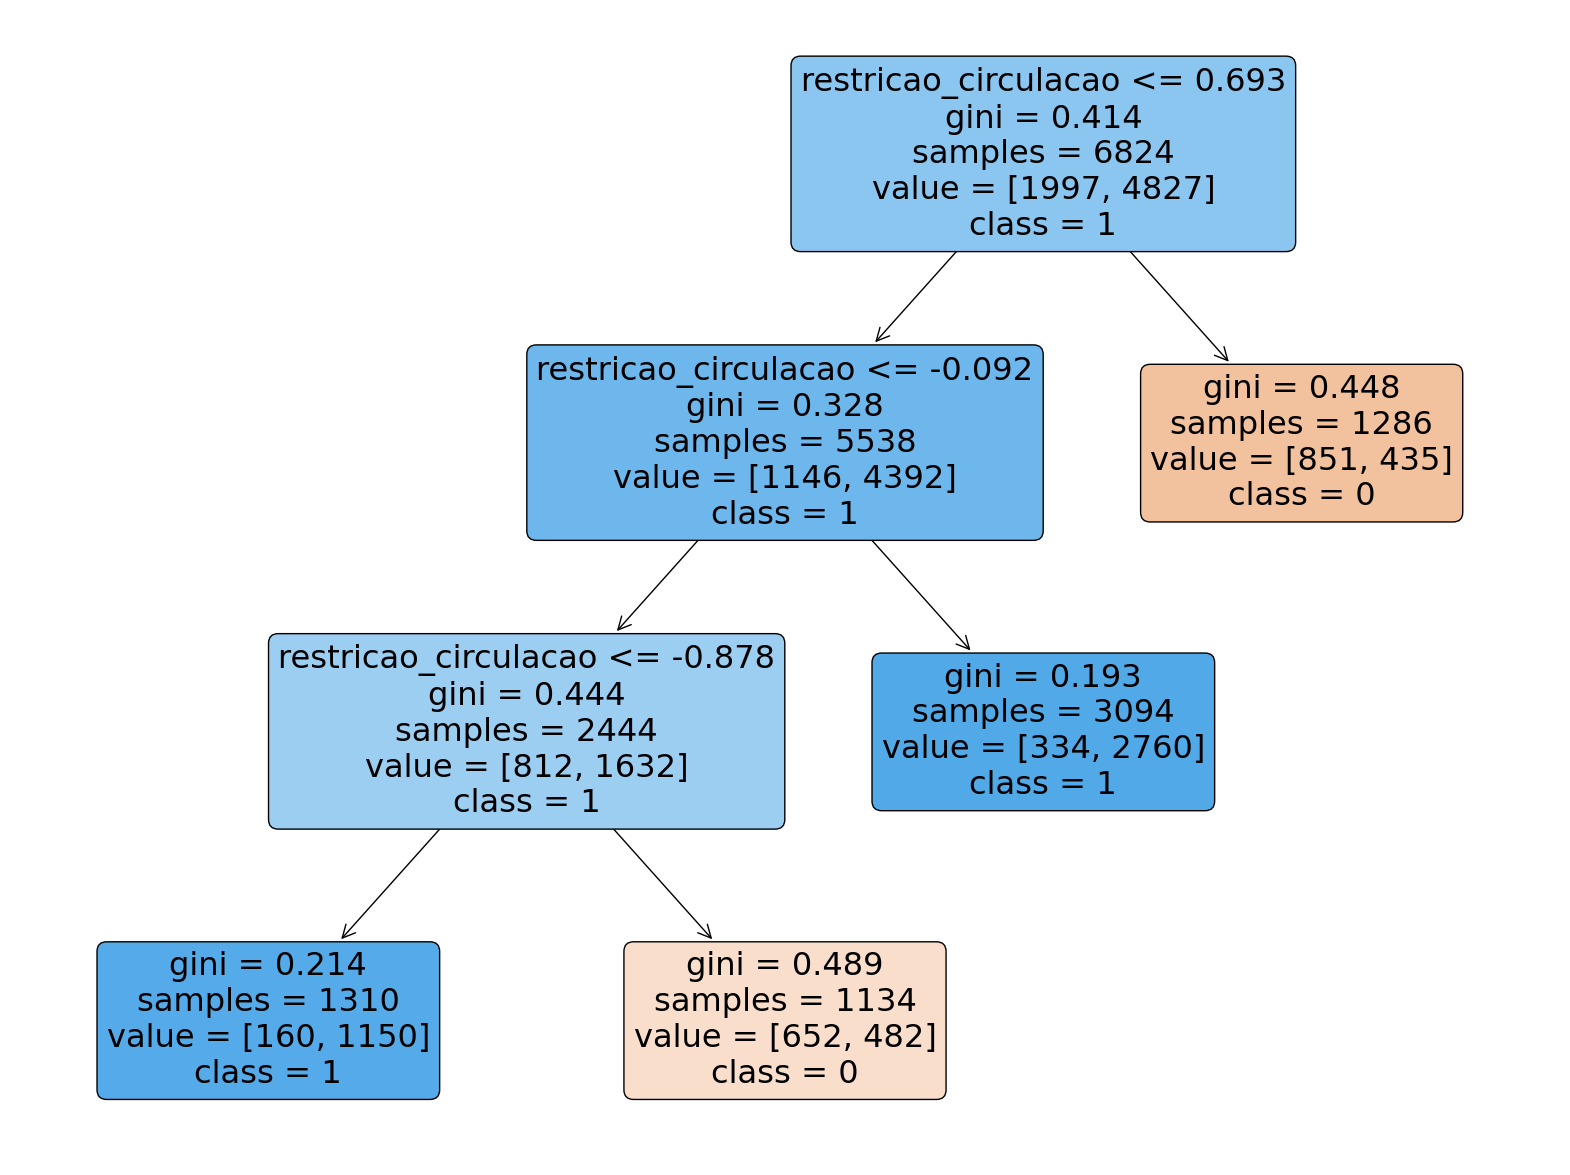

In [182]:
encoders = {}
for col in dados.columns:
    if dados[col].dtype == 'object':
        dados[col] = dados[col].astype(str)
        
        le = LabelEncoder()
        dados[col] = le.fit_transform(dados[col])
        encoders[col] = le
# Normalizando os dados
scaler = StandardScaler()
VIs = dados.drop(columns=["impacto"])
standardized_data = scaler.fit_transform(VIs)
VIs = pd.DataFrame(standardized_data, columns=VIs.columns)

# Definindo a variável dependente
VD = dados["impacto"]

# Dividindo os dados em conjuntos de treino e teste
VItreino, VIteste, VDtreino, VDteste = train_test_split(VIs, VD, test_size=0.3, random_state=1)

# Criando o modelo
classificador = DecisionTreeClassifier(criterion="gini", ccp_alpha=0.008)
modeloGini = classificador.fit(VItreino, VDtreino)
# Convertendo classes para strings
class_names = [str(cls) for cls in modeloGini.classes_]

# Plotando a árvore de decisão
plt.figure(figsize=(20,15))
tree.plot_tree(modeloGini, filled=True, feature_names=VItreino.columns, rounded=True,
               class_names=class_names)
plt.show()

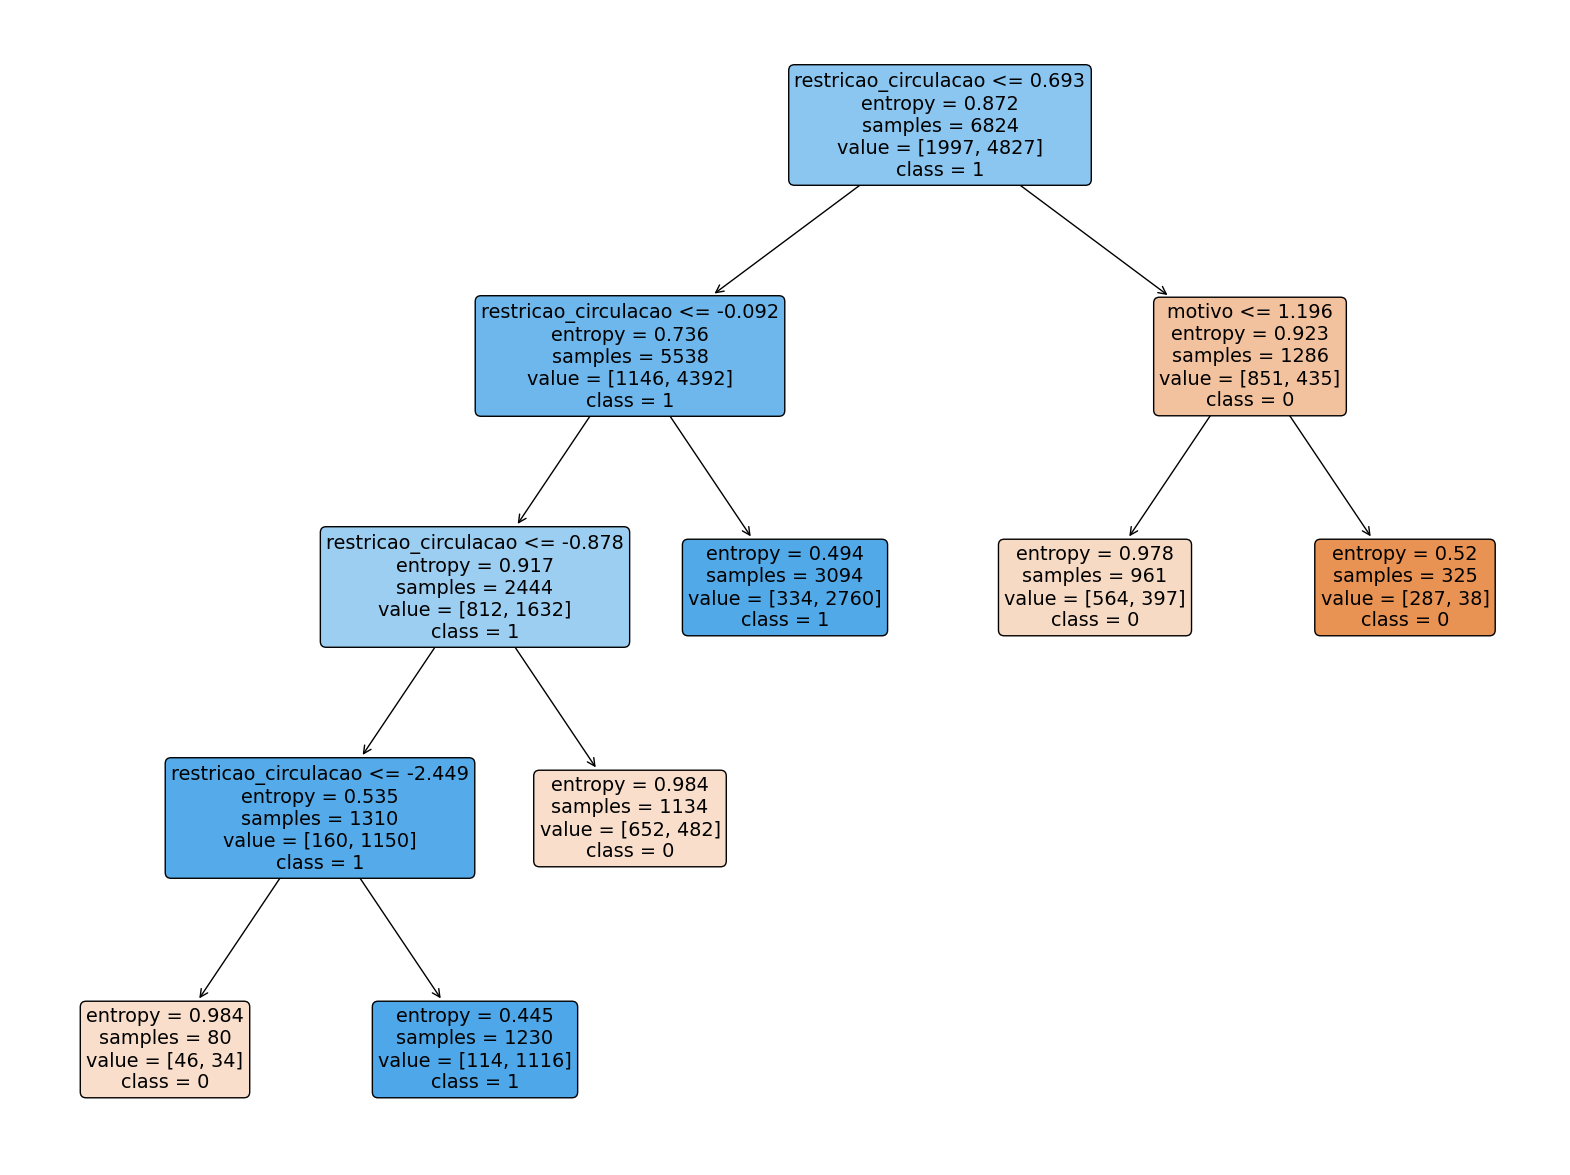

In [183]:
# Normalizando os dados
scaler = StandardScaler()
VIs = dados.drop(columns=["impacto"])
standardized_data = scaler.fit_transform(VIs)
VIs = pd.DataFrame(standardized_data, columns=VIs.columns)

# Definindo a variável dependente
VD = dados["impacto"]

# Dividindo os dados em conjuntos de treino e teste
VItreino, VIteste, VDtreino, VDteste = train_test_split(VIs, VD, test_size=0.3, random_state=1)

# Criando o modelo
classificador = DecisionTreeClassifier(criterion="entropy", ccp_alpha=0.008)
modeloEntrop = classificador.fit(VItreino, VDtreino)

# Convertendo classes para strings
class_names = [str(cls) for cls in modeloEntrop.classes_]

# Plotando a árvore de decisão
plt.figure(figsize=(20,15))
tree.plot_tree(modeloEntrop, filled=True, feature_names=VItreino.columns, rounded=True,  
               class_names=class_names)
plt.show()


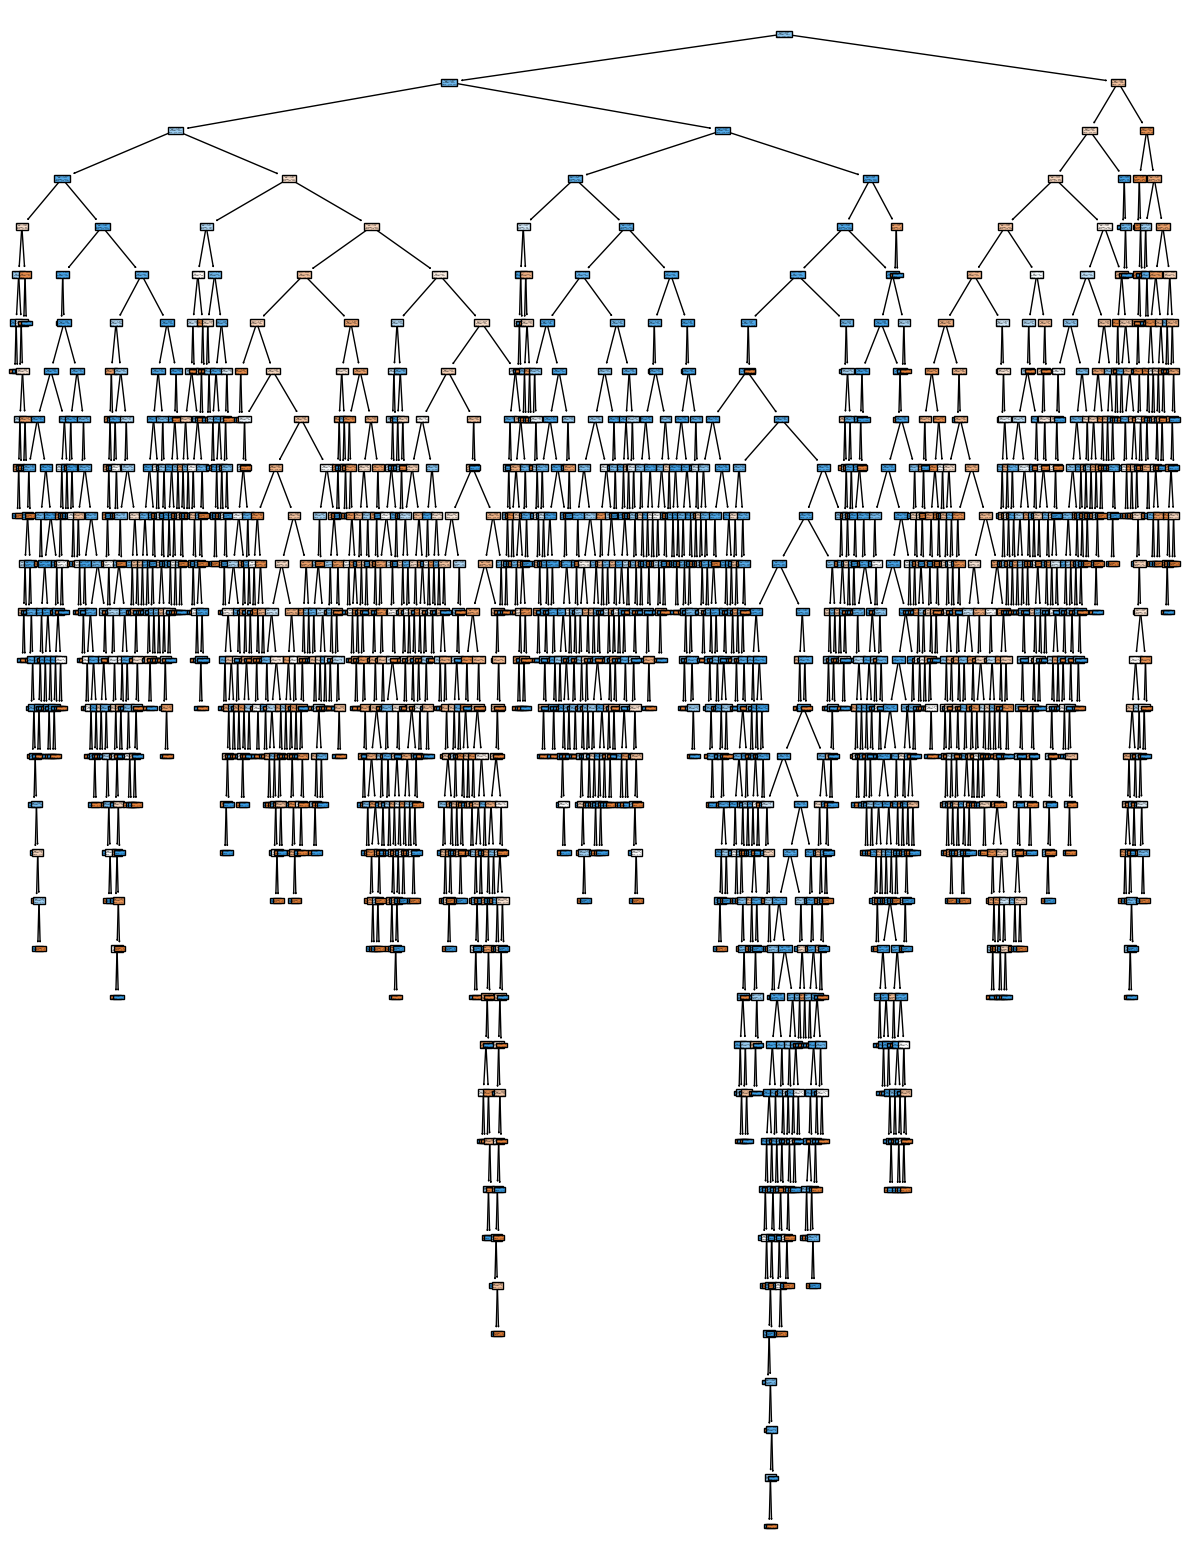

In [184]:
classificador=DecisionTreeClassifier(criterion= "gini")
modelo = classificador.fit (VItreino, VDtreino)
plt.figure(figsize=(15,20))
plot_tree(modelo, filled=True)
plt.show()

Cada nó da árvore de decisão gerada representa uma decisão baseada em um dos recursos (colunas), levando a dois nós filhos.

Devido à profundidade desta árvore, pode-se concluir que existe um sobreajuste, ou seja, árvore de decisão é demasiado complexa ao ponto de aprender não só os padrões subjacentes aos dados de treino, mas também o ruído e as anomalias presentes nos dados.

In [185]:
# Agora, para decodificar como queremos que mostre os dados categoricos e não em números
for col in dados.columns:
    if col in encoders:
        dados[col] = encoders[col].inverse_transform(dados[col])

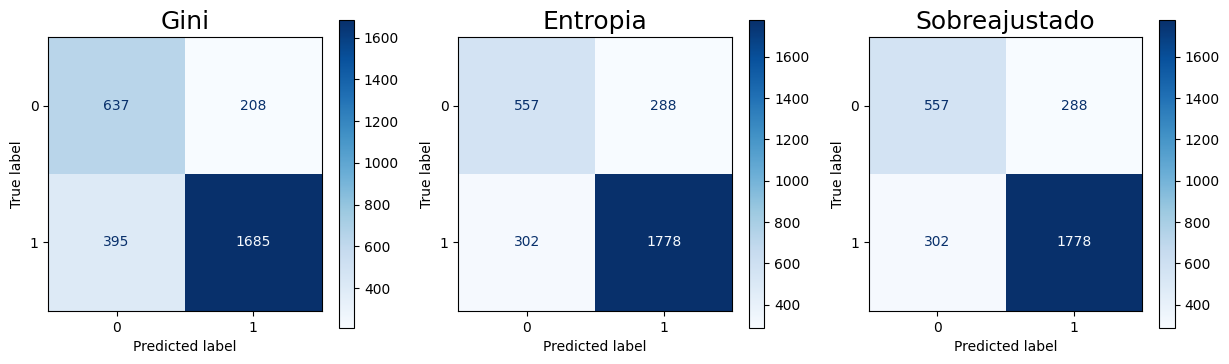

In [186]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, cohen_kappa_score, matthews_corrcoef

modeloEntrop = classificador.fit (VItreino, VDtreino)
prevGini = modeloGini.predict(VIteste)
prevEntrop = modeloEntrop.predict(VIteste)
prevSobre = modelo.predict(VIteste)
fig, eixos = plt.subplots(1,3, figsize=(15,4))
for (prev,col,titulo) in zip([prevGini, prevEntrop, prevSobre],range(3),["Gini","Entropia","Sobreajustado"]):
    ConfusionMatrixDisplay.from_predictions(VDteste, prev, ax=eixos[col], cmap=plt.cm.Blues)
    eixos[col].set_title(titulo, fontsize=18)
    

O código importa a classe `ConfusionMatrixDisplay` do módulo `sklearn.metrics`. Em seguida, ajusta um modelo chamado `modeloEntrop` usando um classificador e conjuntos de treino `VItreino` e `VDtreino`.

Depois disso, o código faz previsões usando três modelos diferentes: `modeloGini`, `modeloEntrop` e `modelo`. As previsões são armazenadas nas variáveis `prevGini`, `prevEntrop` e `prevSobre`, respetivamente.

Em seguida, o código cria uma figura com três subplots, cada um destinado a exibir uma matriz de confusão para as previsões de um dos modelos. As matrizes de confusão são criadas usando a função `ConfusionMatrixDisplay.from_predictions`, que aceita as previsões e os valores reais (`VDteste`), além de um eixo específico para plotar.

Cada subplot é intitulado com o nome do modelo correspondente ("Gini", "Entropia" ou "Sobreajustado"), e a matriz de confusão é exibida com um mapa de cores azul.



In [187]:
from pandas import concat
concat ({'original':VD.value_counts()/len(VD)*100,
         'teste':VDteste.value_counts()/len(VDteste)*100,
         'treino':VDtreino.value_counts()/len(VDtreino)*100}, axis=1).round(1)

,original,teste,treino
impacto,,,
1,70.8,71.1,70.7
0,29.2,28.9,29.3


O código importa a função `concat` da biblioteca `pandas`. Em seguida, ele usa essa função para concatenar as contagens de valores de três conjuntos de dados diferentes (`original`, `teste` e `treino`), normalizados como percentagens do tamanho total de cada conjunto de dados. O resultado é arredondado para uma casa decimal.

A saída é uma tabela que mostra a distribuição percentual dos valores em cada conjunto de dados. Por exemplo, no conjunto de dados `original`, o valor `1` ocorre em 70.8% das instâncias, enquanto o valor `0` ocorre em 29.2% das instâncias. As distribuições percentuais para os conjuntos de dados `teste` e `treino` são semelhantes.



In [188]:
from pandas import DataFrame

DataFrame({'treino':[modelo.score(VItreino,VDtreino)*100],
           'teste':[modelo.score(VIteste,VDteste)*100]}, index=['accuracy']).round(1)

,treino,teste
accuracy,100.0,79.8


C:\Users\silva\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



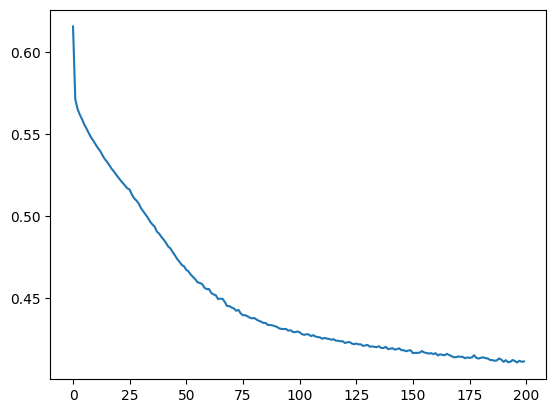

In [189]:
from sklearn.neural_network import MLPClassifier

classificador=MLPClassifier()
modelo = classificador.fit (VItreino.values, VDtreino.values)
plt.plot(modelo.loss_curve_)
plt.show()

Neste gráfico, consegue-se visualizar uma 'curva de perda' durante o treino de um modelo de rede neuronal. À medida que a curva decresce, esta indica que o modelo aprende e reduz os erros existentes.

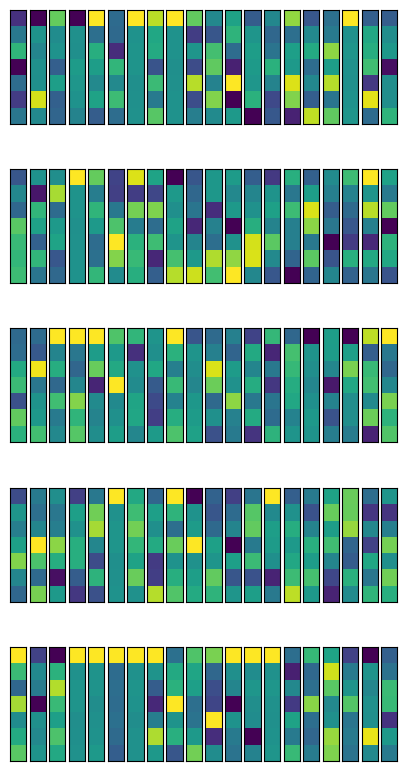

In [190]:
fig, axes = plt.subplots(5, 20, figsize=(5,10)) 
pesoMin, pesoMax = modelo.coefs_[0].min(), modelo.coefs_[0].max()
for coef, ax in zip(modelo.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(7,1), vmin=.5*pesoMin, vmax=.5*pesoMax)
    ax.set_xticks([])
    ax.set_yticks([])

In [191]:
classificador=MLPClassifier(activation='logistic', solver='lbfgs', verbose=True, hidden_layer_sizes=(400,), alpha=0.01, max_iter=1000, early_stopping=True)

modeloQN = classificador.fit (VItreino.values, VDtreino.values)

DataFrame({'erro': [modeloQN.loss_], 'func. activação saída':[modeloQN.out_activation_],
           'nº de iterações': [modeloQN.n_iter_], 'nós de saída':[modeloQN.n_outputs_],
          'nº de camadas':[modeloQN.n_layers_]}, index=["estatísticas"]).T

,estatísticas
erro,0.57128
func. activação saída,logistic
nº de iterações,23
nós de saída,1
nº de camadas,3


In [192]:
def gridSearch (mini: float, maxi: float, solver: str):
    if mini > maxi:
        return "o máximo tem de ser maior do que o mínimo!"
    if solver not in {"adam", "sgd", "lbfgs"}:
        return "use um solver válido: ""adam"", ""sgd"", ""lbfgs"" "
    txCob=[]
    txAprend=[]
    for i in range (0, 20):
        txAprend.append(mini+i*(maxi-mini)/20)
        classificador=MLPClassifier(activation='logistic', solver=solver, hidden_layer_sizes=(80,), alpha=0.002, learning_rate_init=txAprend[i], max_iter=900)
        modelo = classificador.fit (VItreino, VDtreino)
        txCob.append(modelo.score(VIteste,VDteste)*100)
        print("modelo ", i,)
        print("tx de aprendizagem = ", round (txAprend[i], 5), " accuracy = ", round(txCob[i], 1))
    plt.plot(txAprend, txCob, '-')

modelo  0
tx de aprendizagem =  0.001  accuracy =  71.8
modelo  1
tx de aprendizagem =  0.00145  accuracy =  72.2
modelo  2
tx de aprendizagem =  0.0019  accuracy =  72.2
modelo  3
tx de aprendizagem =  0.00235  accuracy =  72.5
modelo  4
tx de aprendizagem =  0.0028  accuracy =  72.4
modelo  5
tx de aprendizagem =  0.00325  accuracy =  72.4
modelo  6
tx de aprendizagem =  0.0037  accuracy =  72.3
modelo  7
tx de aprendizagem =  0.00415  accuracy =  72.9
modelo  8
tx de aprendizagem =  0.0046  accuracy =  72.4
modelo  9
tx de aprendizagem =  0.00505  accuracy =  72.4
modelo  10
tx de aprendizagem =  0.0055  accuracy =  73.1
modelo  11
tx de aprendizagem =  0.00595  accuracy =  72.3
modelo  12
tx de aprendizagem =  0.0064  accuracy =  72.5
modelo  13
tx de aprendizagem =  0.00685  accuracy =  72.1
modelo  14
tx de aprendizagem =  0.0073  accuracy =  73.3
modelo  15
tx de aprendizagem =  0.00775  accuracy =  72.5
modelo  16
tx de aprendizagem =  0.0082  accuracy =  73.3
modelo  17
tx de 

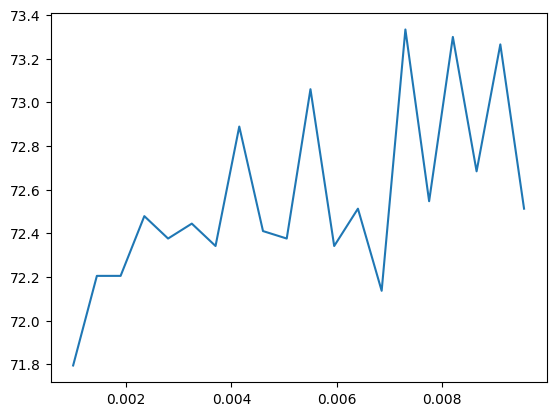

In [193]:
gridSearch (0.001, 0.01, 'sgd')

O gráfico gerado mostra a precisão do modelo relativamente à taxa de aprendizagem, onde cada ponto representa um modelo treinado com uma taxa de aprendizagem específica. O propósito deste tipo de gráfico centra-se na procura da taxa de aprendizagem que resulta na maior precisão do modelo.

Isto obtêm-se através da execução de uma função designada de 'grid_search' que permite realizar uma pesqusa em grelha para otimizar a taxa de aprendizagem de um classificador MLP ('Multilayered Perceptron').


modelo  0
tx de aprendizagem =  0.003  accuracy =  72.5
modelo  1
tx de aprendizagem =  0.00305  accuracy =  72.1
modelo  2
tx de aprendizagem =  0.0031  accuracy =  73.1
modelo  3
tx de aprendizagem =  0.00315  accuracy =  72.3
modelo  4
tx de aprendizagem =  0.0032  accuracy =  72.2
modelo  5
tx de aprendizagem =  0.00325  accuracy =  72.3
modelo  6
tx de aprendizagem =  0.0033  accuracy =  72.3
modelo  7
tx de aprendizagem =  0.00335  accuracy =  72.5
modelo  8
tx de aprendizagem =  0.0034  accuracy =  72.4
modelo  9
tx de aprendizagem =  0.00345  accuracy =  72.3
modelo  10
tx de aprendizagem =  0.0035  accuracy =  72.3
modelo  11
tx de aprendizagem =  0.00355  accuracy =  72.4
modelo  12
tx de aprendizagem =  0.0036  accuracy =  72.6
modelo  13
tx de aprendizagem =  0.00365  accuracy =  72.3
modelo  14
tx de aprendizagem =  0.0037  accuracy =  72.3
modelo  15
tx de aprendizagem =  0.00375  accuracy =  73.2
modelo  16
tx de aprendizagem =  0.0038  accuracy =  73.2
modelo  17
tx de 

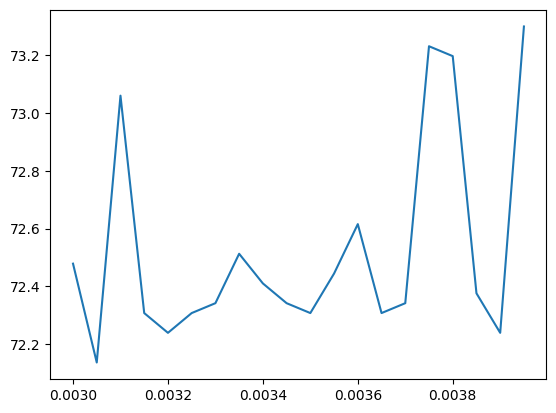

In [194]:
gridSearch (0.003, 0.004, 'sgd')

In [195]:
# obter o modelo
classificador=MLPClassifier(activation='logistic', solver="sgd", hidden_layer_sizes=(80,), alpha=0.0026, learning_rate_init=0.00365, max_iter=900)
modeloSGD = classificador.fit (VItreino.values, VDtreino.values)
# calculo das taxas de cobertura
DataFrame({'treino':[modeloSGD.score(VItreino.values,VDtreino.values)*100],
           'teste':[modeloSGD.score(VIteste.values,VDteste.values)*100]}, index=['accuracy']).round(1)

,treino,teste
accuracy,72.3,72.7


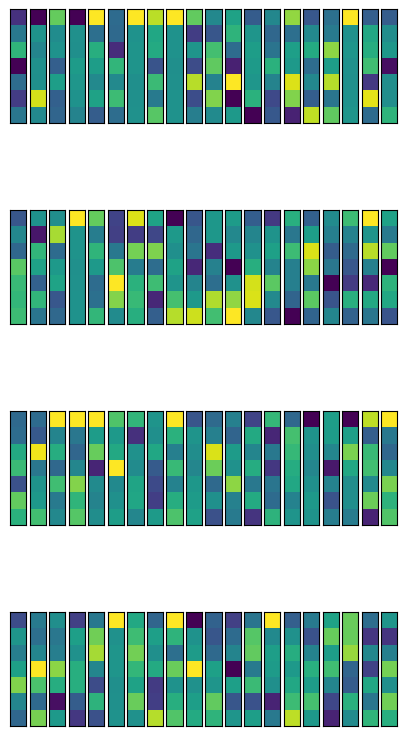

In [196]:
fig, axes = plt.subplots(4, 20, figsize=(5,10)) 
pesoMin, pesoMax = modelo.coefs_[0].min(), modelo.coefs_[0].max()
for coef, ax in zip(modelo.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(7,1), vmin=.5*pesoMin, vmax=.5*pesoMax)
    ax.set_xticks([])
    ax.set_yticks([])

In [197]:
prev = modelo.predict(VIteste.values)
prevSGD = modeloSGD.predict(VIteste.values)
prevQN = modeloQN.predict(VIteste.values)
DataFrame({'Adam': [accuracy_score(VDteste, prev), cohen_kappa_score(VDteste, prev), matthews_corrcoef(VDteste, prev)],
          'SGD': [accuracy_score(VDteste, prevSGD), cohen_kappa_score(VDteste, prevSGD), matthews_corrcoef(VDteste, prevSGD)],
          'qNewton': [accuracy_score(VDteste, prevQN), cohen_kappa_score(VDteste, prevQN), matthews_corrcoef(VDteste, prevQN)]
          }, index=['precisão', 'k de Cohen', 'fi de Matthews']).round(2)

,Adam,SGD,qNewton
precisão,0.80,0.73,0.73
k de Cohen,0.49,0.11,0.13
fi de Matthews,0.49,0.19,0.20


Nesta secção, fez-se uma análise dos três modelos diferentes testados: 'Adam', 'SGD' & 'QNewton'.

1. O modelo de 'Adam' obteve maior precisão e maiores valores no que diz respeito ao 'k de Cohen' e o 'fi de Matthews', o que indica que este modelo tem um bom equilibrio entre sensibilidade e especificidade, com uma correlação positiva entre as previsões e observações reais. 
2. O modelo 'SGD' obteve menores valores para as três métricas, e por consequência pode não ser o melhor modelo a seguir para este conjunto de dados específicos. 
3. O modelo 'QNewton' tem valores semelhantes ao 'SGD', ainda que ligeiramente melhores.

Em conclusão, o modelo 'Adam' parece ser mais indicado para este conjunto de dados tendo em conta estas métricas.

In [198]:
from sklearn.inspection import permutation_importance
featPerf = permutation_importance (modeloQN, VIteste, VDteste, n_repeats=10, random_state=0)
tabPerf=DataFrame({'médias': featPerf.importances_mean, 'desv.pad.':featPerf.importances_std},
          index=VIs.columns).round(2)*100
tabPerf.sort_values(by='médias', inplace = True, ascending = False)
tabPerf

C:\Users\silva\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning:

X has feature names, but MLPClassifier was fitted without feature names

C:\Users\silva\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning:

X has feature names, but MLPClassifier was fitted without feature names

C:\Users\silva\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning:

X has feature names, but MLPClassifier was fitted without feature names

C:\Users\silva\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning:

X has feature names, but MLPClassifier was fitted without feature names

C:\Users\silva\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning:

X has feature names, but MLPClassifier was fitted without feature names

C:\Users\silva\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: U

,médias,desv.pad.
restricao_circulacao,3.0,0.0
motivo,1.0,0.0
morada,0.0,0.0
periodos_condicionamentos,0.0,0.0
position,0.0,0.0
hora_inicio_condicionamento,0.0,0.0
hora_fim_condicionamento,0.0,0.0
